In [207]:
import jax.numpy as jnp
from jax import jit, grad
import jax
from jax.experimental import checkify
import matplotlib.pyplot as plt
from IPython.display import HTML
import sys
sys.path.append("stellar-mesh-integration/")
from mesh_generation import (icosphere, vertex_to_polar, face_center,
                             apply_pulsation, mesh_polar_vertices,
                             apply_spherical_harm_pulsation, spherical_harmonic)
from celluloid import Camera
from spectrum import *

In [208]:
v, f, a, c, m, vm = icosphere(500)

In [209]:
rotation_matrix_x = lambda theta: jnp.array([
    [1, 0, 0],
    [0, jnp.cos(theta), -jnp.sin(theta)],
    [0, jnp.sin(theta), jnp.cos(theta)]
])

rotation_matrix_x_prim = lambda theta: jnp.array([
    [0, 0, 0],
    [0, -jnp.sin(theta), -jnp.cos(theta)],
    [0, jnp.cos(theta), -jnp.sin(theta)]
])

rotation_matrix_y = lambda theta: jnp.array([
    [jnp.cos(theta), 0, jnp.sin(theta)],
    [0, 1, 0],
    [-jnp.sin(theta), 0, jnp.cos(theta)]
])

rotation_matrix_y_prim = lambda theta: jnp.array([
    [-jnp.sin(theta), 0, jnp.cos(theta)],
    [0, 0, 0],
    [-jnp.cos(theta), 0, -jnp.sin(theta)]
])

rotation_matrix_z = lambda theta: jnp.array([
    [jnp.cos(theta), -jnp.sin(theta), 0],
    [jnp.sin(theta), jnp.cos(theta), 0],
    [0, 0, 1]
])

rotation_matrix_z_prim = lambda theta: jnp.array([
    [-jnp.sin(theta), -jnp.cos(theta), 0],
    [jnp.cos(theta), -jnp.sin(theta), 0],
    [0, 0, 0]
])

def generate_frame(phase1, theta, max_ampl):
    ampl1 = max_ampl*jnp.sin(phase1)
    vel1 = max_ampl*jnp.cos(phase1)
    # def apply_spherical_harm_pulsation(verts, centers, faces, magnitude, m, n)
    # return vert_offsets, faces, areas, centers, center_offsets, sph_ham.reshape((-1, 1)), center_sph_ham.reshape((-1, 1))
    _, _, areas, _, center_offsets, _, c_mags = apply_spherical_harm_pulsation(v, c, f, ampl1, 1, 2.)
    rotated_centers = jnp.matmul(c, rotation_matrix_z(theta))
    tan_vel = jnp.matmul(c, rotation_matrix_z_prim(theta))
    return vel1*c_mags, rotation_matrix_z(theta), tan_vel, areas, center_offsets+rotated_centers

In [210]:
_, _, _, _, co = generate_frame(0., 0, 10)

In [211]:
generate_frames = jax.jit(jax.vmap(generate_frame, in_axes=(0, 0, None)))

In [212]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

cmap = mpl.cm.turbo
n = 100

p1s, thetas = jnp.linspace(0, 2*np.pi, n), jnp.linspace(0, 4*jnp.pi, n)
    
all_vels, rot_mats, tan_vels, all_areas, all_centers = generate_frames(p1s, thetas, 1.1)

all_vels = np.nan_to_num(np.array(all_vels))
tan_vels = np.nan_to_num(np.array(tan_vels))

los = jnp.array([0., 1., 0.])
rotation = 20.
pulsation_velocity = 10.

los_rot_vels = rotation*jnp.nan_to_num(jnp.dot(tan_vels/jnp.linalg.norm(tan_vels, axis=2).reshape((n, -1, 1)), los)).reshape((n, -1, 1))
los_puls_vels = pulsation_velocity*jnp.nan_to_num(jnp.multiply(all_vels, jnp.dot(all_centers/jnp.linalg.norm(all_centers, axis=2).reshape((n, -1, 1)), los).reshape((n, -1, 1))))

los_vels = los_rot_vels+los_puls_vels

norm = mpl.colors.Normalize(vmin=los_vels.min(), vmax=los_vels.max())

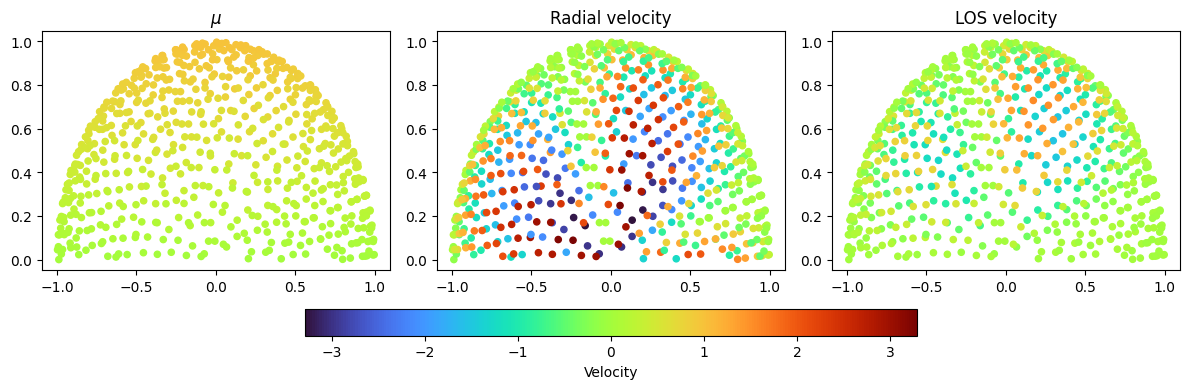

In [213]:
i = 10

fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(2, 9, height_ratios=[9, 1])

sv = all_centers[i]
mu = jnp.dot(sv/jnp.linalg.norm(sv, axis=1).reshape((-1, 1)), los)
mu_mask = mu>0

sv = sv[mu_mask]
v = all_vels[i][mu_mask]

local_rot = jnp.nan_to_num(jnp.dot(sv/jnp.linalg.norm(sv, axis=1).reshape((-1, 1)), los).reshape((-1, 1)))
local_puls = pulsation_velocity*jnp.nan_to_num(v.reshape((-1, 1)))
local_puls_cast = pulsation_velocity*jnp.nan_to_num(jnp.multiply(v, jnp.dot(sv/jnp.linalg.norm(sv, axis=1).reshape((-1, 1)), los).reshape((-1, 1))))

cmap = plt.get_cmap('turbo')
local_norm = mpl.colors.Normalize(vmin=np.array([local_rot.min(), local_puls.min(), local_puls_cast.min()]).min(),
                                  vmax=np.array([local_rot.max(), local_puls.max(), local_puls_cast.max()]).max())
# Set up colormap and normalization

ax1 = fig.add_subplot(gs[0, :3])
ax1.scatter(sv[:, 0], sv[:, 1], s=20.,
            c=local_rot,
            cmap='turbo', norm=local_norm)
ax1.set_title('$\mu$')

ax2 = fig.add_subplot(gs[0, 3:6])
scatter= ax2.scatter(sv[:, 0], sv[:, 1], s=20.,
            c=local_puls,
            cmap='turbo', norm=local_norm)
ax2.set_title('Radial velocity')

ax3 = fig.add_subplot(gs[0, 6:])
ax3.scatter(sv[:, 0], sv[:, 1], s=20.,
            c=local_puls_cast,
            cmap='turbo', norm=local_norm)
ax3.set_title('LOS velocity')

cax = fig.add_subplot(gs[-1, 2:7])
cbar = fig.colorbar(scatter, cax=cax, orientation='horizontal')
cbar.set_label('Velocity');
plt.tight_layout()

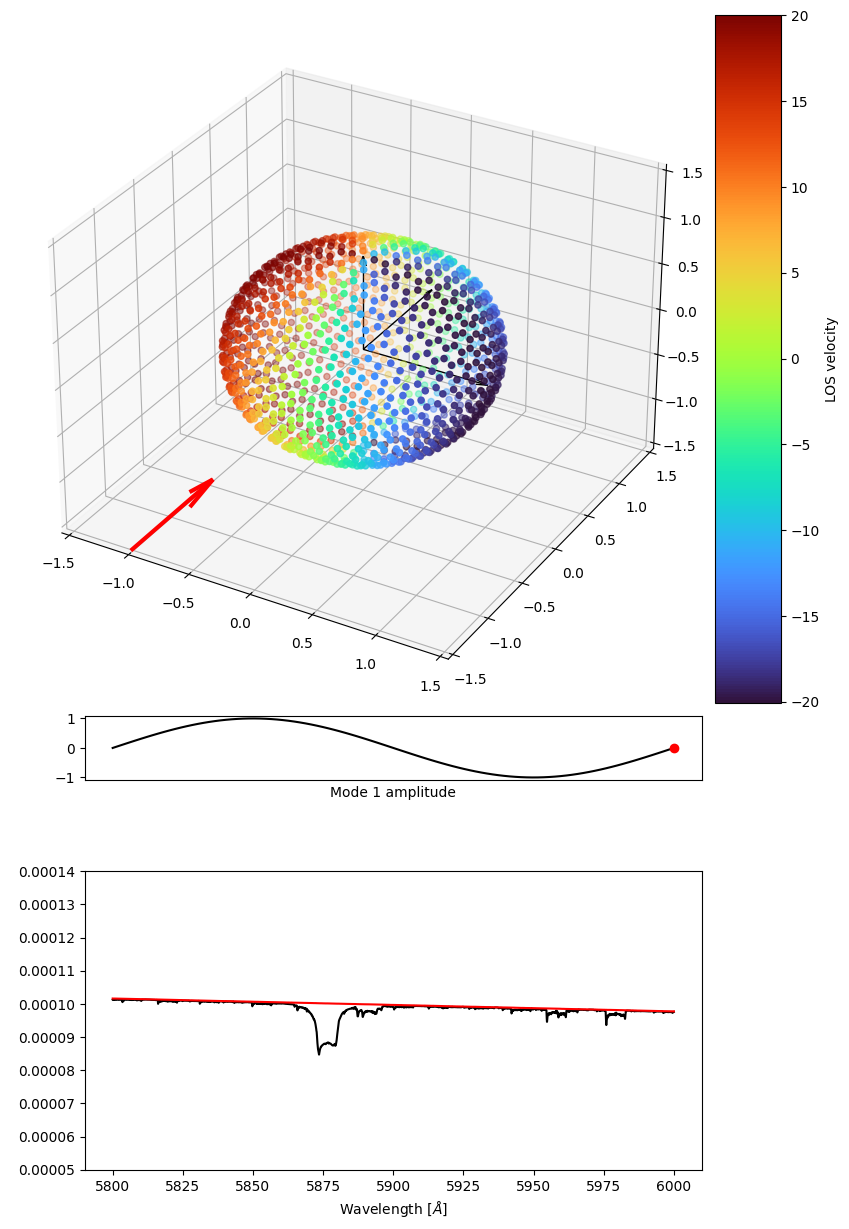

In [223]:
fig = plt.figure(figsize=(10, 15))
spec = fig.add_gridspec(15, 10)
ax1 = fig.add_subplot(spec[:9, :9], projection='3d') #spec[:9], 
ax2 = fig.add_subplot(spec[:9, 9])
ax3 = fig.add_subplot(spec[9, 1:-1])
ax4 = fig.add_subplot(spec[11:, 1:-1])
camera = Camera(fig)

ax1.set_xlim3d(-1.5, 1.5);
ax1.set_ylim3d(-1.5, 1.5);
ax1.set_ylim3d(-1.5, 1.5);

LOG_WAVELENGTHS = jnp.linspace(jnp.log10(5800), jnp.log10(6000), 10000)

x, y, z = np.array([[0,0,0],[0,0,0],[0,0,0]])
qu, qv, qw = np.array([[1.,0,0], [0,1., 0],[0,0,1.]])

for i, (sv, v) in enumerate(zip(all_centers, all_vels)):

    ax1.quiver(0., -3., 0., *los, color='red', linewidth=3.)
    p = ax1.scatter(sv[:, 0], sv[:, 1], sv[:, 2], c=los_vels[i], cmap=cmap, norm=norm);

    rqu = jnp.matmul(qu, rot_mats[i])
    rqv = jnp.matmul(qv, rot_mats[i])
    rqw = jnp.matmul(qw, rot_mats[i])

    ax1.quiver(x, y, z, rqu, rqv, rqw, arrow_length_ratio=0.1, color="black", linewidth=1.)
    
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_zlim(-1.5, 1.5)

    ax3.scatter(p1s[i], np.sin(p1s[i]), color='red', zorder=2)

    ax3.plot(p1s, np.sin(p1s), color='black', zorder=1)
    ax3.set_xlabel('Mode 1 amplitude')
    ax3.xaxis.set_ticklabels([])
    ax3.xaxis.set_ticks([])
    
    mus = -1.*jnp.nan_to_num(jnp.dot(sv/jnp.linalg.norm(sv, axis=1).reshape((-1, 1)), los))
    mu_mask = mus>0
    atmo = spectrum_flash_sum(LOG_WAVELENGTHS, all_areas[i][mu_mask].reshape((-1, 1)), mus[mu_mask], los_vels[i][mu_mask], 256)
    ax4.plot(jnp.linspace(5800, 6000, 10000), np.array(atmo[1]), color='red', zorder=1)
    ax4.plot(jnp.linspace(5800, 6000, 10000), np.array(atmo[0]), color='black', zorder=0)
    
    ax4.set_xlabel('Wavelength [$\AA$]')
    ax4.set_ylim(0.00005, 0.00014)
    
    camera.snap()

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax2)
cbar.set_label('LOS velocity')

anim = camera.animate(blit=True)
anim.save('test_w_spectrum.gif')

In [189]:


mus_mask = sample_mus>0
sample_mus = sample_mus[mus_mask].reshape((-1, 1))
sample_areas = sample_areas[mus_mask].reshape((-1, 1))
vrads = vrads[mus_mask].reshape((-1, 1))


flash_atmosphere_full_vrad = spectrum_flash_sum(LOG_WAVELENGTHS, sample_areas, sample_mus, vrads, 256)

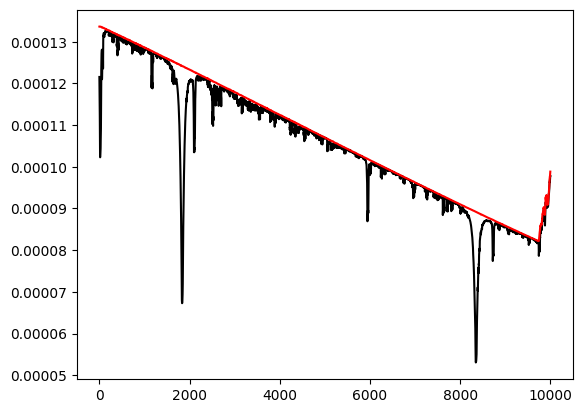

In [190]:
plt.plot(np.array(flash_atmosphere_full_vrad[1]), color='red', zorder=1)
plt.plot(np.array(flash_atmosphere_full_vrad[0]), color='black', zorder=0)